In [1]:
import pandas as pd
import numpy as np
from functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st # for Cumulative Distribution Function in VdW score 

Load the dataset

In [2]:
df = pd.read_parquet('datasets/pre_processing.parquet')

Check time distribution of observations

In [3]:
# count number of years per id
obs_per_id = df.groupby('mun_istat')['year'].nunique()

# count how many ids have 1 year, 2 years, etc.
count_by_years = obs_per_id.value_counts().sort_index()

print(count_by_years)

year
1        2
2        1
3       21
4        5
5        1
7       38
8        7
9        6
10      21
11    7771
Name: count, dtype: int64


In [4]:
# keep only ids with listings over 11 years - balanced panel data
ids_eleven = obs_per_id[obs_per_id == 11].index

# filter the data
df = df[df['mun_istat'].isin(ids_eleven)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 548349 entries, 0 to 553988
Data columns (total 48 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   mun_istat                548349 non-null  object  
 1   year                     548349 non-null  int64   
 2   sector                   548349 non-null  category
 3   type                     548349 non-null  object  
 4   condition                548349 non-null  category
 5   mun_key                  548349 non-null  object  
 6   mun_name_x               548349 non-null  object  
 7   mun_name_norm_x          548349 non-null  object  
 8   region                   548349 non-null  category
 9   prov                     548349 non-null  object  
 10  log_buy_min              548349 non-null  float64 
 11  log_buy_max              548349 non-null  float64 
 12  log_buy_avg              548349 non-null  float64 
 13  population               548349 non-null  float64

Feature engineering

In [26]:
df_clean = df.copy()

(0.0, 50000.0)

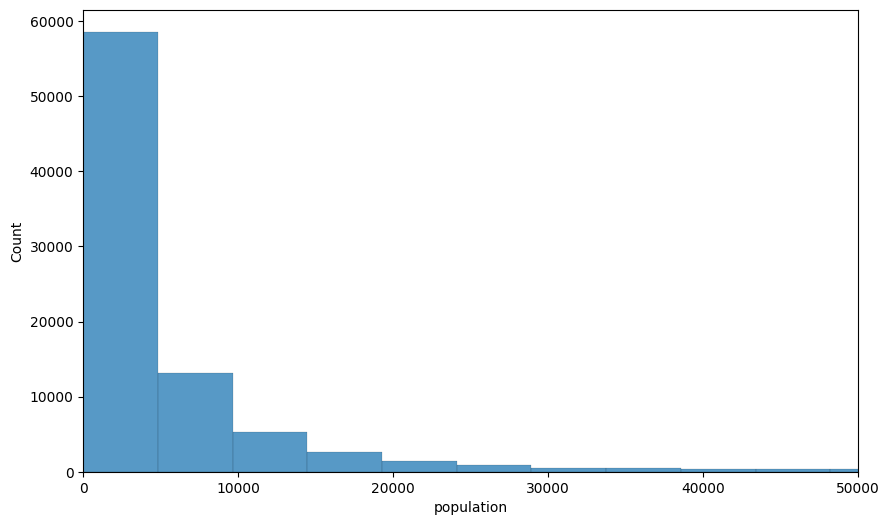

In [27]:
# check distribution of listings per population
plt.figure(figsize = (10,6))
sns.histplot(data = df_clean.groupby(['mun_istat', 'year']).agg({'population':'mean'}), x = 'population')
plt.xlim(0,50000)

Review with quantiles-like classes (more emirically defensible)

In [28]:
# create different classes of municipalities based on population. The two sources below provides too many classes. Lower classes are shrunk into two classes. 
# (https://finanzalocale.interno.gov.it/docum/studi/varie/200707varclass.html#:~:text=In%20dettaglio%2C%20i%20comuni%20risultano,abitanti%2C%20come%20di%20seguito%20descritto.
# https://www.rgs.mef.gov.it/_Documenti/VERSIONE-I/Selezione_normativa/D-Lgs-/DLgs18-08-2000_267.pdf_clean)

def classify_mun(pop):
    if pop < 3000:
        return "Small"      # many small municipalities
    elif pop < 10000:
        return "Medium"           # bulk of the dataset
    elif pop < 50000:
        return "Large"          # typical mid-size cities
    elif pop < 150000:
        return "Very large"           # larger cities
    else:
        return "Metropoly"      # major metropolitan areas

df_clean["mun_class_pop"] = df_clean["population"].apply(classify_mun)

print(df_clean['mun_class_pop'].value_counts())

mun_class_pop
Small         231437
Medium        177398
Large         117955
Very large     17182
Metropoly       4377
Name: count, dtype: int64


Log transform

In [29]:
# clear null values in population
df_clean = df_clean.dropna()

In [30]:
# apply log transformation to typically skewed variables (population, income, surface, real GDP) - PURE ELASTICITY
log_var = [
    'population','median_income','real_gdp'
]

for col in log_var:
    df_clean['log_' + col] = np.log(df_clean[col])

c:\Users\HP\Desktop\Traineeship\Code\.venv_housing\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [31]:
# logged differenced values - FOR VISUALISATION ONLY
centered_value = [
    'log_buy_avg', 'log_population','log_median_income'
]

for col in centered_value:
    df_clean[col + "_diff"] = (
    df_clean.groupby("mun_istat")[col]
      .diff()
)

Immigration and emigration ratios

In [32]:
# total number of immigrants, emigrants, and net movements (standardized per 100 inhabitants) - SEMI-ELASTICITY
df_clean['prov_immigration'] = ((df_clean['abroad_in'] + df_clean['nation_in']) / df_clean['population']) * 100

df_clean['prov_emigration'] = ((df_clean['abroad_out'] + df_clean['nation_out']) / df_clean['population']) * 100

df_clean['prov_net_movements'] = ((df_clean['prov_immigration'] - df_clean['prov_emigration']) / df_clean['population']) * 100

Pre / After -COVID dummy 

In [33]:
df_clean['covid'] = np.where(df_clean['year'] < 2020, 0, 1)

Tourism variables

In [34]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 548349 entries, 0 to 553988
Data columns (total 59 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   mun_istat                548349 non-null  object  
 1   year                     548349 non-null  int64   
 2   sector                   548349 non-null  category
 3   type                     548349 non-null  object  
 4   condition                548349 non-null  category
 5   mun_key                  548349 non-null  object  
 6   mun_name_x               548349 non-null  object  
 7   mun_name_norm_x          548349 non-null  object  
 8   region                   548349 non-null  category
 9   prov                     548349 non-null  object  
 10  log_buy_min              548349 non-null  float64 
 11  log_buy_max              548349 non-null  float64 
 12  log_buy_avg              548349 non-null  float64 
 13  population               548349 non-null  float64

In [35]:
# total number of hotel beds
hotel_col = [
    'five_stars_count',
    'four_stars_count',
    'three_stars_count',
    'two_stars_count',
    'one_stars_count'
]

df_clean['hotel_count'] = df_clean[hotel_col].sum(axis = 1).astype(int)

# drop hotel_col
df_clean = df_clean.drop(columns = hotel_col)

# two variables are computed for a better overview of hotel presence in a municipality
# HOTEL PRESSURE ON TOURISM SECTOR - ratio between hotel beds (total beds - other accomodations bed) and total beds (per 100 beds) - LOG-LEVEL (SEMI-ELASTICITY)
df_clean['ratio_hotel_beds'] = np.where(df_clean['tot_beds'] == 0, 0, ((df_clean['tot_beds'] - df_clean['tot_acc_beds']) / df_clean['tot_beds']) * 100)

# HOTEL PRESSURE ON MUNICIPALITY - ratio between hotel beds and population (per 100 inhabitants) - LOG-LEVEL (SEMI-ELASTICITY)
df_clean['ratio_hotel_mun'] = ((df_clean['tot_beds'] - df_clean['tot_acc_beds']) / df_clean['population']) * 100

In [36]:
# three variables are computed for a better overview of holiday dwellings impact on the tourism sector and on municipalities
# STR PRESSURE ON TOURISM SECTOR - ratio between holiday dwellings bed and total beds (per 100 beds) - LOG-LEVEL (SEMI-ELASTICITY)
df_clean['ratio_str_beds'] = np.where(df_clean['tot_beds'] == 0, 0, (df_clean['holiday_dwelling_beds'] / df_clean['tot_beds']) * 100) 

# STR PRESSURE ON MUNICIPALITY (1)  - ratio of holiday dwellings and population (per 100 dwellings) - LOG-LEVEL (SEMI-ELASTICITY)
df_clean['ratio_str_mun'] = (df_clean['holiday_dwelling_count'] / df_clean['dwellings']) * 100

# STR PRESSURE ON MUNICIPALITY (2)  - ratio of holiday beds and population (per 100 inhabitants) - LOG-LEVEL (SEMI-ELASTICITY)
df_clean['ratio_str_mun_beds'] = (df_clean['holiday_dwelling_beds'] / df_clean['population']) * 100

In [37]:
# measure the ratio between total arrivals and population (per 100 inhabitants) - LOG-LEVEL (SEMI-ELASTICITY)
df_clean['ratio_arrivals'] = (df_clean['tot_arrivals'] / df_clean['population']) * 100

# measure the ratio between total foreigner arrivals and population (per 100 inhabitants) - LOG-LEVEL (SEMI-ELASTICITY)
df_clean['ratio_arrivals_foreigners'] = (df_clean['tot_arrivals_foreigners'] / df_clean['population']) * 100

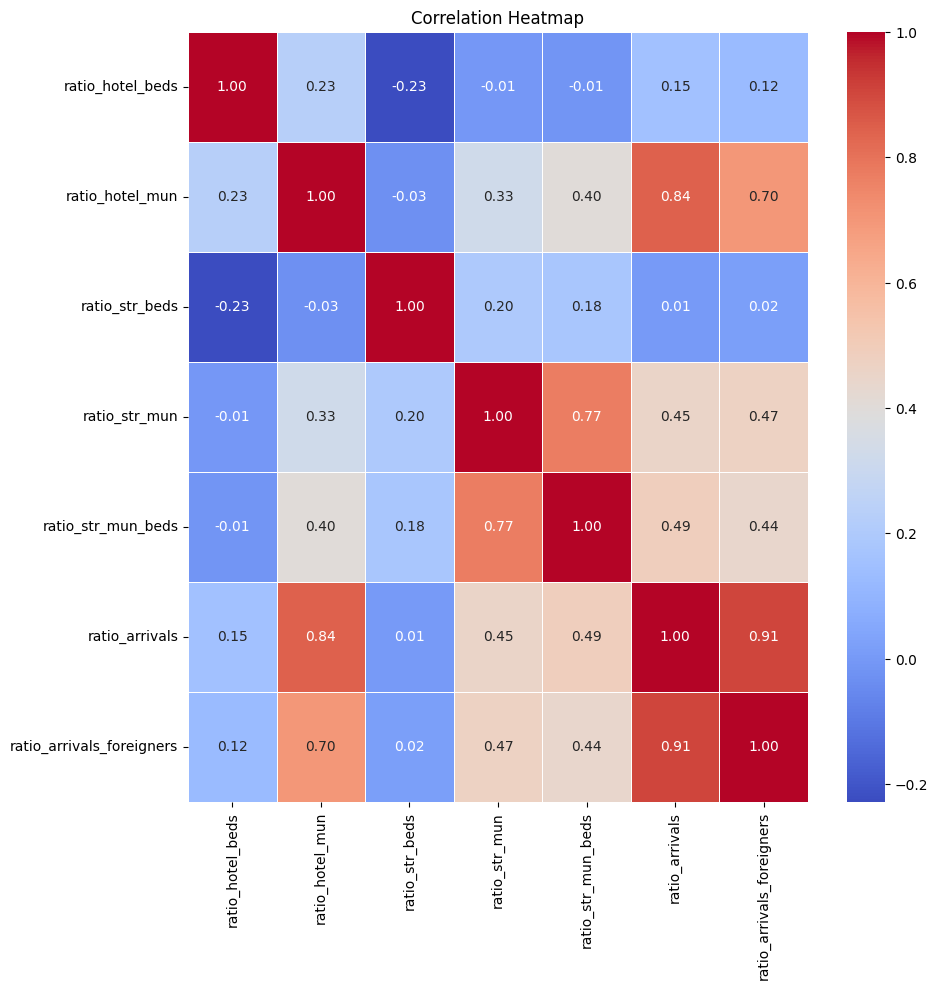

In [38]:
# correlation matrix
# Correlation matrix
var_corr = [
    'ratio_hotel_beds',
    'ratio_hotel_mun',
    'ratio_str_beds',
    'ratio_str_mun',
    'ratio_str_mun_beds',
    'ratio_arrivals',
    'ratio_arrivals_foreigners'
]

matrix = df_clean[var_corr].corr()

plt.figure(figsize=(10,10))
sns.heatmap(matrix, annot = True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Tourism index - VdW score

In [39]:
# compute Van der Waerden score as a tourist index - consider ratios
# define the function
def van_der_waerden_score(x):
    # create a rank
    ranks = x.rank(method='average')
    n = len(x)
    # define the score between 0 and 1
    score = (ranks / (n + 1))
    # compute the VdM score with CDF (For a given value x, what is the probability that a random variable is less than or equal to x?)
    vdW_scores = st.norm.ppf(score)
    return vdW_scores

# select relevant variables (ratio_arrivals_foreigners is excluded due to extremely high correlation with ratio_arrivals)
vdw_var = [
    'ratio_hotel_beds',
    'ratio_str_beds',
    'ratio_hotel_mun',
    'ratio_str_mun',
    'ratio_str_mun_beds',
    'ratio_arrivals'
]

for col in vdw_var:
    df_clean[col + '_vdw'] = van_der_waerden_score(df_clean[col])

# composite index based on VdW scores (average value)
df_clean['tourism_score'] = df_clean[[v + '_vdw' for v in vdw_var]].mean(axis=1)

In [40]:
# check minimum and maximum tourism score
print("Minimum tourism score: ", df_clean['tourism_score'].min())
print("Maximum tourism score: ", df_clean['tourism_score'].max())

Minimum tourism score:  -0.8608596162896752
Maximum tourism score:  2.401349661860794


Create tourism classes 

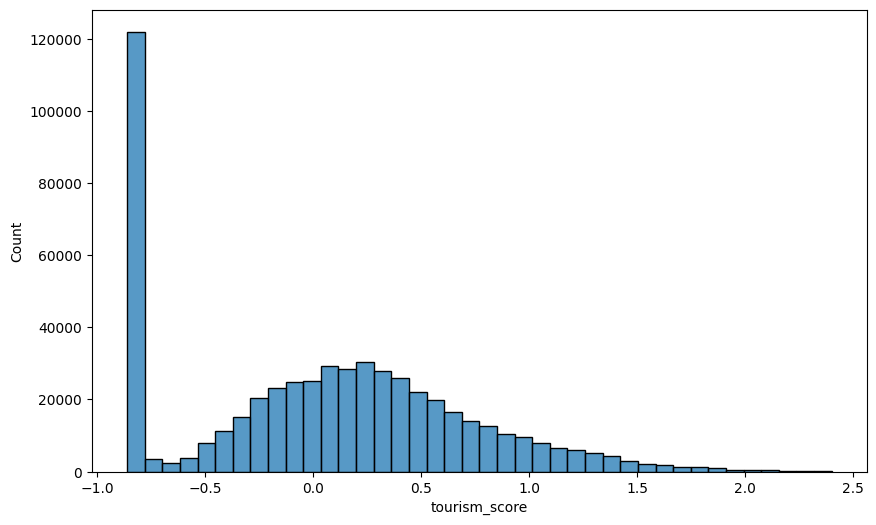

In [41]:
plt.figure(figsize=(10,6))
sns.histplot(data=df_clean, x='tourism_score', bins = 40)
plt.show()

There are many observations with a tourism score close to the minimum. In order not to bias the other classes (including minimum values in the quantiles would fill the lower classes with minimum tourism scores), municipalities with no tourism flow (0 ARRIVALS at year t) are grouped in a separate class ('Zero').

Two classes are computed: one from 2014 (start of the panel dataset) and one from 2024.

In [ ]:
df_clean_2014 = df_clean[df_clean['year'] == 2014].copy()

# identify the minimum score in 2014
min_score = df_clean_2014['tourism_score'].min()

# separate minimum-score municipalities
mask_2014 = df_clean_2014['tot_arrivals'] == 0
df_clean_2014['tourism_class'] = None
df_clean_2014.loc[mask_2014, 'tourism_class'] = 'Zero'

# get the remaining scores
remaining_2014 = df_clean_2014.loc[~mask_2014, 'tourism_score']

# Define custom percentiles (must start at 0 and end at 1)
percentiles = [0, 0.60, 0.85, 1.00]

# Convert percentiles to score thresholds
quantile_edges = remaining_2014.quantile(percentiles).values

quantile_labels = ['Low', 'Moderate', 'High']

df_clean_2014.loc[~mask_2014, 'tourism_class'] = pd.cut(
    remaining_2014,
    bins=quantile_edges,
    include_lowest=True,
    labels=quantile_labels
)

# collapse 2014 classes to municipality level
tourism_class_2014 = (
    df_clean_2014[['mun_istat', 'tourism_class']]
    .drop_duplicates(subset='mun_istat')
)

# safely merge back
df_clean = df_clean.merge(
    tourism_class_2014.rename(columns={'tourism_class': 'tourism_class_2014'}),
    on='mun_istat',
    how='left',
    suffixes=('', '_2014')
)

# check the distribution
print(df_clean['tourism_class_2014'].value_counts())

tourism_class_2014
Zero        262368
Low         170694
Moderate     71928
High         43359
Name: count, dtype: int64


In [45]:
df_clean_2024 = df_clean[df_clean['year'] == 2024].copy()

# identify the minimum score in 2024
min_score = df_clean_2024['tourism_score'].min()

# separate minimum-score municipalities
mask_2024 = df_clean_2024['tot_arrivals'] == 0
df_clean_2024['tourism_class'] = None
df_clean_2024.loc[mask_2024, 'tourism_class'] = 'Zero'

# get the remaining scores
remaining_2024 = df_clean_2024.loc[~mask_2024, 'tourism_score']

# Define custom percentiles (must start at 0 and end at 1)
percentiles = [0, 0.60, 0.85, 1.00]

# Convert percentiles to score thresholds
quantile_edges = remaining_2024.quantile(percentiles).values

quantile_labels = ['Low', 'Moderate', 'High']

df_clean_2024.loc[~mask_2024, 'tourism_class'] = pd.cut(
    remaining_2024,
    bins=quantile_edges,
    include_lowest=True,
    labels=quantile_labels
)

# collapse 2024 classes to municipality level
tourism_class_2024 = (
    df_clean_2024[['mun_istat', 'tourism_class']]
    .drop_duplicates(subset='mun_istat')
)

# safely merge back
df_clean = df_clean.merge(
    tourism_class_2024.rename(columns={'tourism_class': 'tourism_class_2024'}),
    on='mun_istat',
    how='left',
    suffixes=('', '_2024')
)

# check the distribution
print(df_clean['tourism_class_2024'].value_counts())

tourism_class_2024
Low         237379
Zero        152130
Moderate     99721
High         59119
Name: count, dtype: int64


In [47]:
df_clean.to_parquet('datasets/model_data.parquet', index = False)